# ChatGPT Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/08-chatgpt.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/08-chatgpt.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/08-chatgpt.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[document,notebook]"
import evadb
cursor = evadb.connect().cursor()

Note: you may need to restart the kernel to use updated packages.


## Download News Video and ChatGPT UDF 

In [2]:
# Download News Video
!wget -nc "https://www.dropbox.com/s/rfm1kds2mv77pca/russia_ukraine.mp4?dl=0" -O russia_ukraine.mp4

# Download ChatGPT UDF if needed
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/udfs/chatgpt.py -O chatgpt.py

File ‘russia_ukraine.mp4’ already there; not retrieving.


File ‘chatgpt.py’ already there; not retrieving.


### Visualize Video Frame

In [3]:
import cv2
from matplotlib import pyplot as plt

def show_video_frame(input_video_path, show_frame_number = 100):
    vcap = cv2.VideoCapture(input_video_path)
    vcap.set(1, show_frame_number) #1: CAP_PROP_POS_FRAMES    
    ret, frame = vcap.read()  # Read the frame
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)    
    plt.imshow(frame)
    plt.show()
    vcap.release()

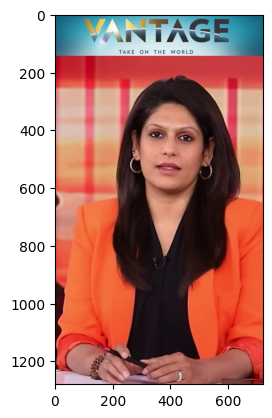

In [4]:
show_video_frame('russia_ukraine.mp4')

## Set your OpenAI API key here

In [5]:
# Set your OpenAI key as an environment variable
import os
#os.environ['OPENAI_KEY'] = 'sk-....................'
open_ai_key = os.environ.get('OPENAI_KEY')

## Run the ChatGPT UDF

![OPENAI UDF](chatgpt.png)

In [7]:
# Load the video
cursor.query("DROP TABLE IF EXISTS VIDEOS").df()
cursor.query("LOAD VIDEO 'russia_ukraine.mp4' INTO VIDEOS").df()

,0
0,Number of loaded VIDEO: 1


In [8]:
# Drop the Text Summarization UDF if needed
cursor.query("DROP FUNCTION IF EXISTS SpeechRecognizer;").df()

# Create a Text Summarization UDF using Hugging Face
text_summarizer_udf_creation = """
    CREATE FUNCTION SpeechRecognizer 
    TYPE HuggingFace 
    TASK 'automatic-speech-recognition' 
    MODEL 'openai/whisper-base';
"""
cursor.query(text_summarizer_udf_creation).df()

/home/jarulraj3/eva/test_evadb/lib/python3.10/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,0
0,UDF SpeechRecognizer successfully added to the...


#### Configure Pandas Display

In [9]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [10]:
# Drop the table if needed
cursor.query("DROP TABLE IF EXISTS TEXT_SUMMARY;").df()


# Create a materialized view of the text summarization output
text_summarization_query = """
    CREATE TABLE
    TEXT_SUMMARY AS 
    SELECT SpeechRecognizer(audio) FROM VIDEOS; 
"""
cursor.query(text_summarization_query).df()

/home/jarulraj3/eva/test_evadb/lib/python3.10/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


""


In [11]:
# Run ChatGPT over the Text Summary extracted by Whisper
chatgpt_udf = """
    SELECT ChatGPT('Is this video summary related to Ukraine russia war',text) 
    FROM TEXT_SUMMARY;
"""
cursor.query(chatgpt_udf).df()

,chatgpt.response
0,"Yes, the video summary is related to the Ukraine-Russia war as it discusses how US oil companies are profiting from the conflict."


## Check if it works on an SNL Video

In [12]:
# Download Entertainment Video
!wget -nc "https://www.dropbox.com/s/u66im8jw2s1dmuw/snl.mp4?dl=0" -O snl.mp4

cursor.query("DROP TABLE IF EXISTS SNL_VIDEO;").df()

cursor.query("LOAD VIDEO 'snl.mp4' INTO SNL_VIDEO;").df()

File ‘snl.mp4’ already there; not retrieving.


,0
0,Number of loaded VIDEO: 1


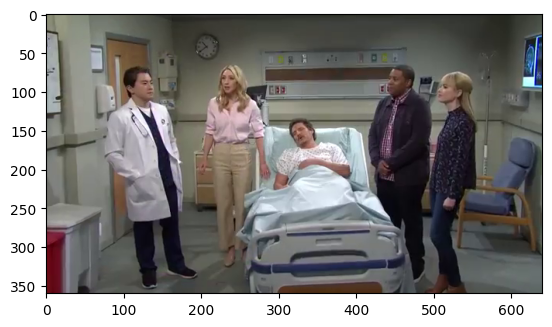

In [13]:
show_video_frame('snl.mp4')

In [14]:
# Drop the table if needed
cursor.query("DROP TABLE IF EXISTS SNL_TEXT_SUMMARY;").df()


# Create a materialized view of the text summarization output
text_summarization_query = """
    CREATE TABLE
    SNL_TEXT_SUMMARY AS 
    SELECT SpeechRecognizer(audio) FROM SNL_VIDEO;
"""
cursor.query(text_summarization_query).df()

/home/jarulraj3/eva/test_evadb/lib/python3.10/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


""


### ChatGPT: Is this video summary related to Ukraine War?

In [15]:
# Run ChatGPT over the Text Summary extracted by Whisper
chatgpt_udf = """
    SELECT ChatGPT('Is this video summary related to Ukraine russia war',text) 
    FROM SNL_TEXT_SUMMARY;
"""
cursor.query(chatgpt_udf).df()

,chatgpt.response
0,"No, this video summary is not related to the Ukraine-Russia war. It is about a man waking up from a coma and experiencing confusion and temporary changes in personality and speech."


### ChatGPT: Is this video summary related to a hospital?

In [16]:
# Run ChatGPT over the Text Summary extracted by Whisper
chatgpt_udf = """
    SELECT ChatGPT('Is this video summary related to a hospital',text) 
    FROM SNL_TEXT_SUMMARY;
"""
cursor.query(chatgpt_udf).df()

,chatgpt.response
0,"Yes, the video summary is related to a hospital. It features a doctor and a patient who has just woken up from a coma and is experiencing confusion and memory loss. The patient's wife and sister are also present, and the doctor reassures them that the patient's condition is normal and temporary. The video highlights the emotional rollercoaster that patients and their loved ones go through during a hospital stay."
